### Chapter 03: Basic Electronics Review

A notebook to generate EPS/PDF figures for Chapter 2 of the book "Basic Electronics Review".

**Author:** Sivakumar Balasubramanian

In [68]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pathlib
import pandas as pd
import brokenaxes as brokenaxes

In [2]:
# Define Matplotlib plot style
# Maplotlib settings
# Axes ticks labels fontsize
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Axes labels fontsize
plt.rcParams['axes.labelsize'] = 16
# Title fontsize
plt.rcParams['axes.titlesize'] = 16
# Legend fontsize
plt.rcParams['legend.fontsize'] = 12
# All font must be Helvetica
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "text.latex.preamble": r"\usepackage{cmbright}",
})

In [3]:
# Directory details
save_dir = pathlib.Path('../../figures/ch03/')

#### MOSFET iD-vDS Characteristic

In [15]:
def nmos_region(vgs, vds, vtn):
    nmos_cutoff = lambda vgs, vtn: vgs < vtn
    nmos_triode = lambda vgs, vds, vtn: vgs >= vtn and vds < (vgs - vtn)
    nmos_saturation = lambda vgs, vds, vtn: vgs >= vtn and vds >= (vgs - vtn)
    if nmos_cutoff(vgs, vtn):
        return "cutoff"
    elif nmos_triode(vgs, vds, vtn):
        return "triode"
    elif nmos_saturation(vgs, vds, vtn):
        return "saturation"
    else:
        raise ValueError("Invalid NMOS region")

def nmos_id(vgs, vds, vtn):
    # Check the region of operation.
    region = nmos_region(vgs, vds, vtn)
    if region == "cutoff":
        return 0.0
    elif region == "triode":
        return (vgs - vtn) * vds - 0.5 * vds**2
    elif region == "saturation":
        return 0.5 * (vgs - vtn)**2


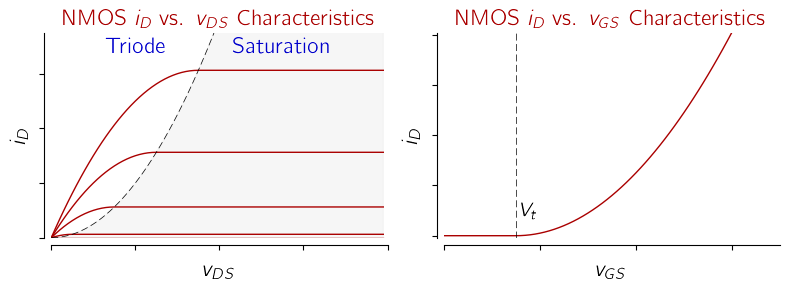

In [17]:
v_gs = np.arange(0.5, 5, 1.0)
v_tn = 1.0
v_ds = np.arange(0, 8, 0.1)

# Plot the i_D versus v_DS for different v_GS values.
fig = plt.figure(figsize=(8, 3.0))
ax = fig.add_subplot(121)
for vgs_val in v_gs:
    i_d = [nmos_id(vgs_val, v_ds_val, v_tn) for v_ds_val in v_ds]
    ax.plot(v_ds, i_d, lw=1, color="#aa0000")
# Triode and Saturation regions
vds_bndry = np.arange(v_tn, 9, 0.1)
id_sat = [nmos_id(vgs_val, vgs_val - v_tn, v_tn) for vgs_val in vds_bndry]
ax.plot(vds_bndry - v_tn, id_sat, lw=0.5, color="#000", dashes=[10, 5])
ax.fill_between(vds_bndry - v_tn, 0, id_sat, color="#eee", alpha=0.5)
ax.set_xlabel('$v_{DS}$')
ax.set_ylabel('$i_D$')
ax.set_title('NMOS $i_{D}$ vs. $v_{DS}$ Characteristics', color="#aa0000")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlim(0, 8)
ax.set_ylim(0, 7.5)
# Add text for the different regions
ax.text(2.0, 6.75, 'Triode', fontsize=16, color='#0000cc', ha='center')
ax.text(5.5, 6.75, 'Saturation', fontsize=16, color='#0000cc', ha='center')

# i_D versus v_GS for different v_DS values.
ax = fig.add_subplot(122)
v_ds = 10
v_tn = 1.5
v_gs = np.arange(0, 7, 0.1)
i_d = [nmos_id(v_gs_val, v_ds, v_tn) for v_gs_val in v_gs]
ax.plot(v_gs, i_d, lw=1, color="#aa0000")
ax.axvline(v_tn, lw=0.5, color="#000", dashes=[10, 5])
ax.text(v_tn + 0.1, 1.0, '$V_{t}$', fontsize=14, color='#000', ha='left')
ax.set_xlabel('$v_{GS}$')
ax.set_ylabel('$i_D$')
ax.set_title('NMOS $i_{D}$ vs. $v_{GS}$ Characteristics', color="#aa0000")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlim(0, 7)
ax.set_ylim(-0.1, 10.1)

plt.tight_layout()

plt.savefig(save_dir / 'fig03-mosfet-iv-curves.svg', format="svg", bbox_inches='tight')
plt.savefig(save_dir / 'fig03-mosfet-iv-curves.pdf', format="pdf", bbox_inches='tight')

## Rectifier circuits with different diode models

In [22]:
from scipy.optimize import root_scalar

def diode_current(Vd, Is=1e-12, n=1.5, V_T=0.02585):
    return Is * (np.exp(Vd / (n * V_T)) - 1)

def solve_diode_voltage(Vin, R_L=100, Is=1e-12, n=1.5, V_T=0.02585):
    """
    Solve for diode voltage v_D in a simple diode-resistor circuit.

    Parameters:
    ----------
    Vin : float
        Input voltage in volts.
    R_L : float
        Load resistance in ohms.
    Is : float
        Reverse saturation current in amperes.
    n : float
        Ideality factor.
    V_T : float
        Thermal voltage (typically ~0.02585V at room temperature).

    Returns:
    -------
    v_D : float
        Voltage drop across the diode.
    """

    def f(v_D):
        return Vin - v_D - R_L * diode_current(v_D, Is, n, V_T)

    # Use root_scalar with a reasonable bracket around the expected v_D
    result = root_scalar(f, bracket=[0, Vin], method='brentq')
    
    if result.converged:
        return result.root
    else:
        raise RuntimeError("Root finding did not converge.")

In [23]:
ts = 0.001
t = np.arange(0, 10, ts)
v_in = 2 * np.sin(2 * np.pi * 1 * t)
# Output voltage for a half wave rectifier for differnet diode models
R_L = 100   # Load resistance
v_d = 0.7   # Forward voltage drop of the diode
r_d = 10    # Diode forward resistance
v_out1 = np.where(v_in > 0, v_in, 0)
v_out2 = np.where(v_in > v_d, v_in - v_d, 0)
v_out3 = np.where(v_in > v_d, R_L * (v_in - v_d) / (R_L + r_d), 0)
v_out4 = np.array([_vin - solve_diode_voltage(_vin) for _vin in v_in])

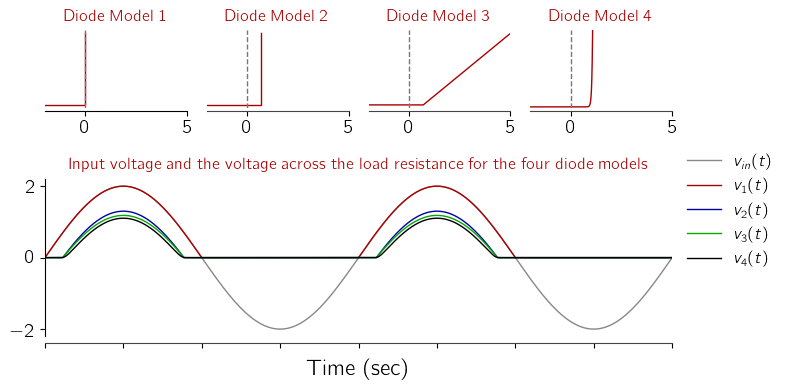

In [24]:
fig = plt.figure(figsize=(8, 4))
# Subplot grid
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 2])

# Diode model 1
# Diode IV plot
ax = fig.add_subplot(gs[0, 0])
ax.plot([-5, 0, 0], [0, 0, 5], lw=1, color="#aa0000")
ax.axvline(0, lw=1, ls="dashed", color="#777")
# Customize spine appearance
axis_color = "#444444"
ax.spines['bottom'].set_position(('outward', 2))
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xlim(-2, 5)
ax.set_title("Diode Model 1", fontsize=12, color="#aa0000")

# Diode model 2
# Diode IV plot
ax = fig.add_subplot(gs[0, 1])
ax.plot([-5, v_d, v_d], [0, 0, 5], lw=1, color="#aa0000")
ax.axvline(0, lw=1, ls="dashed", color="#777")
# Customize spine appearance
axis_color = "#444444"
ax.spines['bottom'].set_position(('outward', 2))
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color(axis_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xlim(-2, 5)
ax.set_title("Diode Model 2", fontsize=12, color="#aa0000")

# Diode model 3
# Diode IV plot
ax = fig.add_subplot(gs[0, 2])
ax.plot([-5, v_d, 5], [0, 0, (5 - v_d) / r_d], lw=1, color="#aa0000")
ax.axvline(0, lw=1, ls="dashed", color="#777")
# Customize spine appearance
axis_color = "#444444"
ax.spines['bottom'].set_position(('outward', 2))
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color(axis_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xlim(-2, 5)
ax.set_title("Diode Model 3", fontsize=12, color="#aa0000")

# Diode model 4
# Diode IV plot
ax = fig.add_subplot(gs[0, 3])
v_diode = np.arange(-5, 5, 0.01)
i_diode = [diode_current(_vd) for _vd in v_diode]
ax.plot(v_diode, i_diode, lw=1, color="#aa0000")
ax.axvline(0, lw=1, ls="dashed", color="#777")
# Customize spine appearance
axis_color = "#444444"
ax.spines['bottom'].set_position(('outward', 2))
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color(axis_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xlim(-2, 5)
ax.set_ylim(-0.02, 1)
ax.set_title("Diode Model 4", fontsize=12, color="#aa0000")

# Output plot
ax = fig.add_subplot(gs[1, :])
ax.plot(t, v_in, lw=1, color="#888", label=r"$v_{in}(t)$")
ax.plot(t, v_out1, lw=1, color="#aa0000", label=r"$v_{1}(t)$")
ax.plot(t, v_out2, lw=1, color="#0000aa", label=r"$v_{2}(t)$")
ax.plot(t, v_out3, lw=1, color="#00aa00", label=r"$v_{3}(t)$")
ax.plot(t, v_out4, lw=1, color="#000", label=r"$v_{4}(t)$")
# Customize spine appearance
axis_color = "#444444"
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_color(axis_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, 2)
ax.set_ylim(-2.2, 2.2)
ax.set_xticklabels([])
ax.legend(
    frameon=False,
    loc='center left',             # align vertically center, left of the box
    bbox_to_anchor=(1.0, 0.8),    # position outside the plot (x=1.05 of axes width)
    ncol=1                         # number of columns in legend
)
ax.set_xlabel("Time (sec)")
ax.set_title("Input voltage and the voltage across the load resistance for the four diode models",
             fontsize=12, color="#aa0000")
plt.tight_layout()

# Save figure
plt.savefig(save_dir / 'fig03-diode-halfwave-plot.svg', format="svg", bbox_inches='tight')
plt.savefig(save_dir / 'fig03-diode-halfwave-plot.pdf', format="pdf", bbox_inches='tight')

### Voltage regulator 1 with 4 diodes.

In [75]:
# Read the output file from LTSpice
data_noload = pd.read_csv("simple_voltage_regulator.txt", sep="\t")
data_load = pd.read_csv("simple_voltage_regulator_load.txt", sep="\t")
data_load_sweep = pd.read_csv("simple_voltage_regulator_load_sweep.txt", sep="\t")

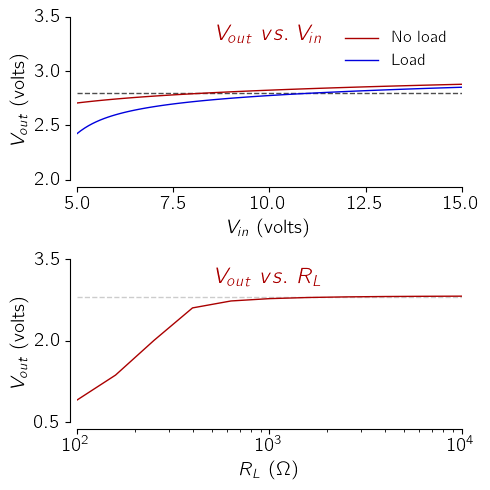

In [96]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(211)
ax.axhline(2.8, color="0.3", lw=1, ls="dashed")
ax.plot(data_noload['vs'], data_noload['V(nout)'], lw=1, color="#aa0000",
        label=r"No load")
ax.plot(data_load['vs'], data_load['V(nout)'], lw=1, color="#0000dd",
        label=r"Load")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("outward", 5))
ax.spines["bottom"].set_position(("outward", 5))
ax.set_xlabel(r"$V_{in}$ (volts)", fontsize=14)
ax.set_ylabel(r"$V_{out}$ (volts)", fontsize=14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("outward", 5))
ax.spines["bottom"].set_position(("outward", 5))
ax.set_xlabel(r"$V_{in}$ (volts)", fontsize=14)
ax.set_ylabel(r"$V_{out}$ (volts)", fontsize=14)
ax.set_xlim(5, 15)
ax.set_ylim(2.0, 3.5)
ax.set_xticks(np.linspace(5, 15, 5))
ax.set_title(r"$V_{out} \,\, vs. \,\, V_{in}$", color="#aa0000", y=0.8);
ax.legend(frameon=False, loc=1)
ax = fig.add_subplot(212)
ax.axhline(2.8, color="0.8", lw=1, ls="dashed")
ax.semilogx(data_load_sweep['rl'], data_load_sweep['V(nout)'], lw=1, color="#aa0000",
        label=r"No load")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("outward", 5))
ax.spines["bottom"].set_position(("outward", 5))
ax.set_xlabel(r"$R_{L}$ ($\Omega$)", fontsize=14)
ax.set_ylabel(r"$V_{out}$ (volts)", fontsize=14)
ax.set_xlim(100, 10000)
ax.set_ylim(0.5, 3.5)
ax.set_yticks(np.linspace(0.5, 3.5, 3))
ax.set_title(r"$V_{out} \,\, vs. \,\, R_{L}$", color="#aa0000", y=0.8)
plt.tight_layout()
# Save figure
plt.savefig(save_dir / 'fig03-diode-simplevoltreg-plot.svg', format="svg", bbox_inches='tight')
plt.savefig(save_dir / 'fig03-diode-simplevoltreg-plot.pdf', format="pdf", bbox_inches='tight')

### Zerner VI characteristics

In [97]:
data_zener = pd.read_csv("zener_regulator.txt", sep="\t")
data_zener

,v1,V(in),V(out),I(D1),I(R1),I(V1)
0,0.000,0.000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.001,0.001,0.001000,-1.380166e-12,-1.392582e-12,-1.380166e-12
2,0.002,0.002,0.002000,-2.735489e-12,-2.735489e-12,-2.735489e-12
3,0.003,0.003,0.003000,-4.066428e-12,-4.066428e-12,-4.066428e-12
4,0.004,0.004,0.004000,-5.373435e-12,-5.373435e-12,-5.373435e-12
...,...,...,...,...,...,...
19996,19.996,19.996,5.101690,-1.489431e-02,-1.489431e-02,-1.489431e-02
19997,19.997,19.997,5.101691,-1.489531e-02,-1.489531e-02,-1.489531e-02
19998,19.998,19.998,5.101692,-1.489631e-02,-1.489631e-02,-1.489631e-02
19999,19.999,19.999,5.101692,-1.489731e-02,-1.489731e-02,-1.489731e-02


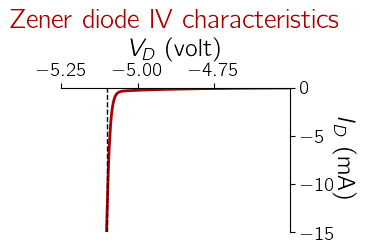

In [ ]:
fig = plt.figure(figsize=(3.5, 0.75 * 3.5))
ax = fig.add_subplot(111)
ax.plot(-data_zener['V(out)'], 1000 * data_zener['I(D1)'], lw=2,
        color="#aa0000")
ax.axvline(-5.1, lw=1, ls="dashed", color="#000")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("data", -4.5))
ax.spines["bottom"].set_position("zero")
ax.tick_params(axis='x', which='both', top=True, bottom=False,
               labeltop=True, labelbottom=False)
ax.tick_params(axis='y', which='both', left=False, right=True,
               labelleft=False, labelright=True)
ax.set_xlim(-5.25, -4.5)
ax.set_ylim(-15, 0)
ax.xaxis.set_label_position('top')
ax.set_xlabel(r"$V_{D}$ (volt)", fontsize=18)
ax.yaxis.set_label_position('right')
ax.set_ylabel(r"$I_{D}$ (mA)", fontsize=18, rotation=270, labelpad=15)
ax.set_xticks(np.linspace(-5.25, -4.75, 3));
ax.set_yticks(np.linspace(-15, 0, 4));
ax.set_title("Zener diode IV characteristics", fontsize=20, color="#aa0000")
plt.tight_layout()

# Save figure
plt.savefig(save_dir / 'fig03-zener-iv-curve.svg', format="svg", bbox_inches='tight')
plt.savefig(save_dir / 'fig03-zener-iv-curve.pdf', format="pdf", bbox_inches='tight')

In [176]:
data_zener_load = pd.read_csv("zener_regulator_load.txt", sep="\t")
data_zener_load_sweep = pd.read_csv("zener_regulator_load_sweep.txt", sep="\t")

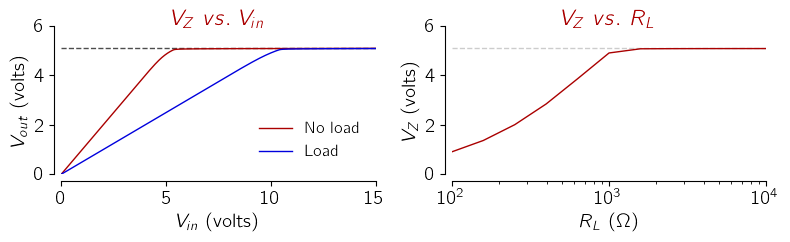

In [201]:
fig = plt.figure(figsize=(8, 2.5))
ax = fig.add_subplot(121)
ax.axhline(5.1, color="0.3", lw=1, ls="dashed")
ax.plot(data_zener['V(in)'], data_zener['V(out)'], lw=1, color="#aa0000",
        label=r"No load")
ax.plot(data_zener_load['V(in)'], data_zener_load['V(out)'], lw=1, color="#0000dd",
        label=r"Load")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("outward", 5))
ax.spines["bottom"].set_position(("outward", 5))
ax.set_xlabel(r"$V_{in}$ (volts)", fontsize=14)
ax.set_ylabel(r"$V_{out}$ (volts)", fontsize=14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("outward", 5))
ax.spines["bottom"].set_position(("outward", 5))
ax.set_xlabel(r"$V_{in}$ (volts)", fontsize=14)
ax.set_ylabel(r"$V_{out}$ (volts)", fontsize=14)
ax.set_xlim(0, 15)
ax.set_ylim(0, 6)
ax.set_xticks(np.linspace(0, 15, 4))
ax.set_title(r"$V_{Z} \,\, vs. \,\, V_{in}$", color="#aa0000", y=0.95);
ax.legend(frameon=False, loc=4)
ax = fig.add_subplot(122)
ax.axhline(5.1, color="0.8", lw=1, ls="dashed")
ax.semilogx(data_zener_load_sweep['rl'], data_zener_load_sweep['V(out)'], lw=1, color="#aa0000",
        label=r"No load")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("outward", 5))
ax.spines["bottom"].set_position(("outward", 5))
ax.set_xlabel(r"$R_{L}$ ($\Omega$)", fontsize=14)
ax.set_ylabel(r"$V_{Z}$ (volts)", fontsize=14)
ax.set_xlim(100, 10000)
ax.set_ylim(0, 6)
ax.set_yticks(np.linspace(0, 6, 4))
ax.set_title(r"$V_{Z} \,\, vs. \,\, R_{L}$", color="#aa0000", y=0.95)
plt.tight_layout()

# # Save figure
plt.savefig(save_dir / 'fig03-diode-zener-voltreg-plot.svg', format="svg", bbox_inches='tight')
plt.savefig(save_dir / 'fig03-diode-zener-voltreg-plot.pdf', format="pdf", bbox_inches='tight')

### BJT Switch

In [29]:
data_bjt = pd.read_csv("bjt_switch_solenoid.txt", sep="\t")

In [30]:
data_bjt

,time,V(c1),V(n001),V(in),V(s),V(c2),V(n002),Ic(Q1),Ib(Q1),Ie(Q1),Ic(Q2),Ib(Q2),Ie(Q2),I(D1),I(L1),I(L2),I(R1),I(R2),I(V1),I(V2)
0,0.000000,5.0,5.003333e-11,0.0,5.0,5.0,5.003333e-11,5.015247e-12,-5.003333e-12,-1.050000e-14,5.015247e-12,-5.003333e-12,-1.050000e-14,0.000000e+00,5.013394e-12,4.914629e-12,-5.003333e-12,-5.003333e-12,1.000667e-11,-9.928045e-12
1,0.001006,5.0,5.003094e-11,0.0,5.0,5.0,5.002479e-11,5.013027e-12,-5.003036e-12,-1.050043e-14,5.013027e-12,-5.002668e-12,-1.049950e-14,1.229172e-30,5.014575e-12,4.955245e-12,-5.003094e-12,-5.002479e-12,1.000570e-11,-1.000300e-11
2,0.002030,5.0,5.003461e-11,0.0,5.0,5.0,5.001288e-11,5.012287e-12,-5.003603e-12,-1.049989e-14,5.013027e-12,-5.001818e-12,-1.050063e-14,-9.867479e-14,5.014083e-12,4.908927e-12,-5.003461e-12,-5.001288e-12,1.000542e-11,-9.998471e-12
3,0.003054,5.0,5.003025e-11,0.0,5.0,5.0,5.007784e-11,5.013767e-12,-5.003033e-12,-1.049968e-14,5.018948e-12,-5.008011e-12,-1.050377e-14,1.973496e-13,5.014089e-12,5.200148e-12,-5.003025e-12,-5.007784e-12,1.001104e-11,-9.980954e-12
4,0.004078,5.0,5.003605e-11,0.0,5.0,5.0,5.006410e-11,5.014507e-12,-5.003661e-12,-1.049956e-14,5.016727e-12,-5.006425e-12,-1.050088e-14,9.867479e-14,5.014707e-12,5.120075e-12,-5.003605e-12,-5.006410e-12,1.001008e-11,-9.980722e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13082,2.997360,5.0,5.002992e-11,0.0,5.0,5.0,5.004268e-11,5.013767e-12,-5.003007e-12,-1.049040e-14,5.014507e-12,-5.004332e-12,-1.050084e-14,3.289160e-14,5.014475e-12,5.044858e-12,-5.002992e-12,-5.004268e-12,1.000734e-11,-1.000951e-11
13083,2.998384,5.0,5.006073e-11,0.0,5.0,5.0,5.003409e-11,5.015988e-12,-5.005925e-12,-1.050198e-14,5.014507e-12,-5.003746e-12,-1.050097e-14,0.000000e+00,5.017947e-12,4.976076e-12,-5.006073e-12,-5.003409e-12,1.000967e-11,-9.973412e-12
13084,2.999408,5.0,5.000991e-11,0.0,5.0,5.0,5.003267e-11,5.011547e-12,-5.000928e-12,-1.050473e-14,5.014507e-12,-5.003517e-12,-1.050106e-14,-3.344743e-26,5.012282e-12,4.977956e-12,-5.000991e-12,-5.003267e-12,1.000444e-11,-9.981031e-12
13085,3.000000,5.0,5.022817e-11,0.0,5.0,5.0,4.998075e-11,5.032649e-12,-5.022453e-12,-1.047718e-14,5.006320e-12,-4.996527e-12,-1.048275e-14,-2.671548e-13,5.033922e-12,4.670162e-12,-5.022817e-12,-4.998075e-12,1.001898e-11,-1.004428e-11


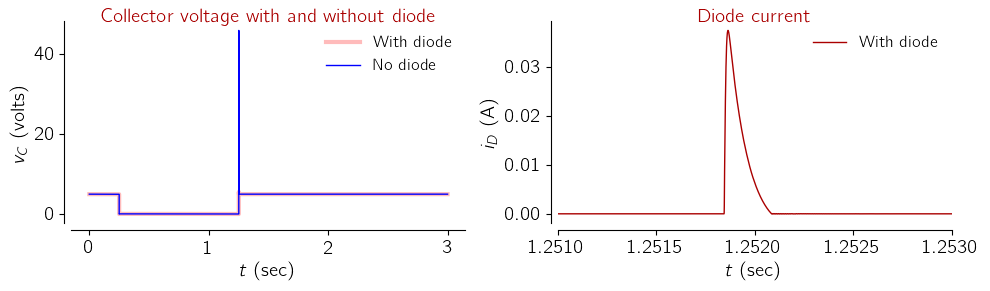

In [80]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(121)
ax.plot(data_bjt['time'], data_bjt['V(c2)'], lw=3, color="#ffbbbb",
        label=r"With diode")
ax.plot(data_bjt['time'], data_bjt['V(c1)'], lw=1, color="#0000ff",
        label=r"No diode")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("outward", 5))
ax.spines["bottom"].set_position(("outward", 5))
ax.set_xlabel(r"$V_{in}$ (volts)", fontsize=14)
ax.set_ylabel(r"$V_{out}$ (volts)", fontsize=14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("outward", 5))
ax.spines["bottom"].set_position(("outward", 5))
ax.set_xlabel(r"$t$ (sec)", fontsize=14)
ax.set_ylabel(r"$v_{C}$ (volts)", fontsize=14)
# ax.set_xlim(0, 15)
# ax.set_ylim(0, 6)
# ax.set_xticks(np.linspace(0, 15, 4))
ax.set_title("Collector voltage with and without diode",
             color="#aa0000", y=0.95, fontsize=14);
ax.legend(frameon=False, loc=1)
ax = fig.add_subplot(122)
ax.plot(data_bjt['time'], data_bjt['I(D1)'], lw=1, color="#aa0000",
        label=r"With diode")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("outward", 5))
ax.spines["bottom"].set_position(("outward", 5))
ax.set_xlabel(r"$V_{in}$ (volts)", fontsize=14)
ax.set_ylabel(r"$V_{out}$ (volts)", fontsize=14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("outward", 5))
ax.spines["bottom"].set_position(("outward", 5))
ax.set_xlabel(r"$t$ (sec)", fontsize=14)
ax.set_ylabel(r"$i_{D}$ (A)", fontsize=14)
ax.set_xlim(1.251, 1.253)
# ax.set_ylim(0, 6)
# ax.set_xticks(np.linspace(0, 15, 4))
ax.set_title("Diode current", color="#aa0000", y=0.95, fontsize=14);
ax.legend(frameon=False, loc=1)
plt.tight_layout()

# Save figure
plt.savefig(save_dir / 'fig03-bjt-switch-solenoid-plot.svg',
            format="svg", bbox_inches='tight')
plt.savefig(save_dir / 'fig03-bjt-switch-solenoid-plot.pdf',
            format="pdf", bbox_inches='tight')

In [4]:
2.5/3.3

0.7575757575757576

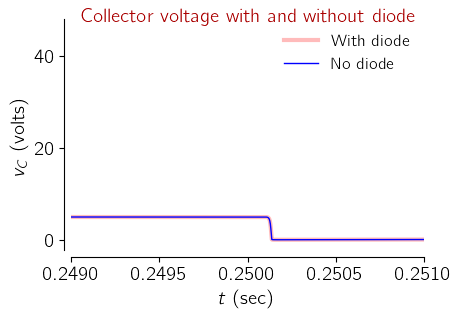

In [84]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(121)
ax.plot(data_bjt['time'], data_bjt['V(c2)'], lw=3, color="#ffbbbb",
        label=r"With diode")
ax.plot(data_bjt['time'], data_bjt['V(c1)'], lw=1, color="#0000ff",
        label=r"No diode")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("outward", 5))
ax.spines["bottom"].set_position(("outward", 5))
ax.set_xlabel(r"$V_{in}$ (volts)", fontsize=14)
ax.set_ylabel(r"$V_{out}$ (volts)", fontsize=14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_position(("outward", 5))
ax.spines["bottom"].set_position(("outward", 5))
ax.set_xlabel(r"$t$ (sec)", fontsize=14)
ax.set_ylabel(r"$v_{C}$ (volts)", fontsize=14)
ax.set_xlim(0.249, 0.251)
# ax.set_ylim(0, 6)
# ax.set_xticks(np.linspace(0, 15, 4))
ax.set_title("Collector voltage with and without diode",
             color="#aa0000", y=0.95, fontsize=14);
ax.legend(frameon=False, loc=1)

In [87]:
data_bjt

,time,V(c1),V(n001),V(in),V(s),V(c2),V(n002),Ic(Q1),Ib(Q1),Ie(Q1),Ic(Q2),Ib(Q2),Ie(Q2),I(D1),I(L1),I(L2),I(R1),I(R2),I(V1),I(V2)
0,0.000000,5.0,5.003333e-11,0.0,5.0,5.0,5.003333e-11,5.015247e-12,-5.003333e-12,-1.050000e-14,5.015247e-12,-5.003333e-12,-1.050000e-14,0.000000e+00,5.013394e-12,4.914629e-12,-5.003333e-12,-5.003333e-12,1.000667e-11,-9.928045e-12
1,0.001006,5.0,5.003094e-11,0.0,5.0,5.0,5.002479e-11,5.013027e-12,-5.003036e-12,-1.050043e-14,5.013027e-12,-5.002668e-12,-1.049950e-14,1.229172e-30,5.014575e-12,4.955245e-12,-5.003094e-12,-5.002479e-12,1.000570e-11,-1.000300e-11
2,0.002030,5.0,5.003461e-11,0.0,5.0,5.0,5.001288e-11,5.012287e-12,-5.003603e-12,-1.049989e-14,5.013027e-12,-5.001818e-12,-1.050063e-14,-9.867479e-14,5.014083e-12,4.908927e-12,-5.003461e-12,-5.001288e-12,1.000542e-11,-9.998471e-12
3,0.003054,5.0,5.003025e-11,0.0,5.0,5.0,5.007784e-11,5.013767e-12,-5.003033e-12,-1.049968e-14,5.018948e-12,-5.008011e-12,-1.050377e-14,1.973496e-13,5.014089e-12,5.200148e-12,-5.003025e-12,-5.007784e-12,1.001104e-11,-9.980954e-12
4,0.004078,5.0,5.003605e-11,0.0,5.0,5.0,5.006410e-11,5.014507e-12,-5.003661e-12,-1.049956e-14,5.016727e-12,-5.006425e-12,-1.050088e-14,9.867479e-14,5.014707e-12,5.120075e-12,-5.003605e-12,-5.006410e-12,1.001008e-11,-9.980722e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13082,2.997360,5.0,5.002992e-11,0.0,5.0,5.0,5.004268e-11,5.013767e-12,-5.003007e-12,-1.049040e-14,5.014507e-12,-5.004332e-12,-1.050084e-14,3.289160e-14,5.014475e-12,5.044858e-12,-5.002992e-12,-5.004268e-12,1.000734e-11,-1.000951e-11
13083,2.998384,5.0,5.006073e-11,0.0,5.0,5.0,5.003409e-11,5.015988e-12,-5.005925e-12,-1.050198e-14,5.014507e-12,-5.003746e-12,-1.050097e-14,0.000000e+00,5.017947e-12,4.976076e-12,-5.006073e-12,-5.003409e-12,1.000967e-11,-9.973412e-12
13084,2.999408,5.0,5.000991e-11,0.0,5.0,5.0,5.003267e-11,5.011547e-12,-5.000928e-12,-1.050473e-14,5.014507e-12,-5.003517e-12,-1.050106e-14,-3.344743e-26,5.012282e-12,4.977956e-12,-5.000991e-12,-5.003267e-12,1.000444e-11,-9.981031e-12
13085,3.000000,5.0,5.022817e-11,0.0,5.0,5.0,4.998075e-11,5.032649e-12,-5.022453e-12,-1.047718e-14,5.006320e-12,-4.996527e-12,-1.048275e-14,-2.671548e-13,5.033922e-12,4.670162e-12,-5.022817e-12,-4.998075e-12,1.001898e-11,-1.004428e-11


(0.248, 0.252)

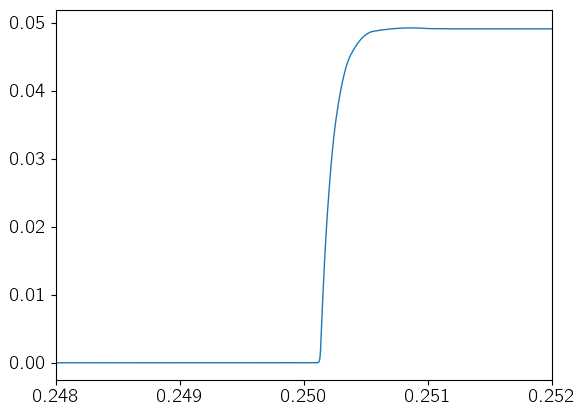

In [93]:
plt.plot(data_bjt['time'], data_bjt['Ic(Q1)'], lw=1)
plt.xlim(0.248, 0.252)

(1.248, 1.252)

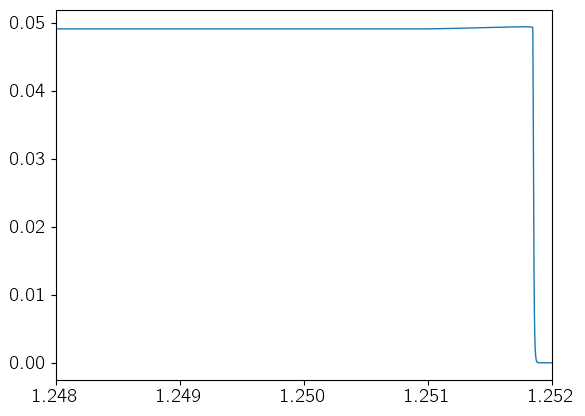

In [96]:
plt.plot(data_bjt['time'], data_bjt['Ic(Q1)'], lw=1)
# plt.plot(data_bjt['time'], data_bjt['Ic(Q2)'], lw=1)
plt.xlim(1.248, 1.252)